# Transfer learning
Not CIFAR10
A quick training using Hymenoptera_data (ants, bees) and pretrained model

## Preparation

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms, models
from torch.optim import lr_scheduler
import numpy as np
import os, copy
import matplotlib.pyplot as plt

In [ ]:
# import zipfile

# zip_ref = zipfile.ZipFile("/content/hymenoptera_data.zip", 'r')
# zip_ref.extractall()
# zip_ref.close()

In [ ]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

batch_size = 32
data_dir = 'hymenoptera_data'
num_workers = os.cpu_count()

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                              data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                      shuffle=True, num_workers=num_workers) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = 'cuda' if torch.cuda.is_available() else 'cpu'

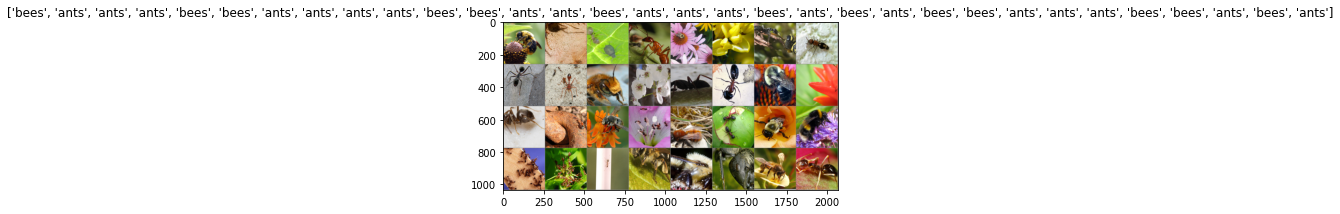

In [ ]:
def imshow(img, title):
  inp = img.permute(1,2,0).numpy()
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  plt.title(title)
  plt.show()

imgs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(imgs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 244
    Root location: hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
           )

## Train function

In [ ]:
def train_model(model, loss_fn, optimizer, scheduler, num_epochs, dataloaders):
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss, running_corrects = 0.0, 0

      for inputs, labels in dataloaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          preds = torch.argmax(outputs, dim=1)

          if phase == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        running_corrects += torch.sum(preds == labels.data)

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print(f'{phase} Loss: {epoch_loss : .4f} Acc: {epoch_acc:.4f}')

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

  print(f'Best val acc: {best_acc:.4f}')

  model.load_state_dict(best_model_wts)
  return model

## Finetune

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

model_conv = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
for param in model_conv.parameters():
  param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_conv.parameters(), lr=1e-3)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_conv = train_model(model_conv,
                         loss_fn, optimizer,
                         step_lr_scheduler,
                         2,
                         dataloaders)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


train Loss:  0.6726 Acc: 0.6025
val Loss:  0.5806 Acc: 0.7255
train Loss:  0.4997 Acc: 0.7623
val Loss:  0.4163 Acc: 0.8693
Best val acc: 0.8693
